In [1]:
import numpy as np
import pandas as pd
import warnings
import random


from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *

from itertools import chain, combinations

from plotnine import *

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')
START_DATE = '1983-01-01'
END_DATE = '2010-01-01'
END_DATE = '2020-01-01'



def powerset(iterable, start=1):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(start, len(s) + 1))


def sharpe_ratio(bond_returns, cash_rate, signal, signal_weights=1):
    """Return the Sharpe ratio for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    sharpe = signal_returns.mean() / signal_returns.std()
    return sharpe


def calc_signal_risk_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns /= signal_returns.std()
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def get_passive_vol_adj_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns -= cash_rate
    risk_free_returns /= risk_free_returns.std()
    risk_free_returns += 1
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def get_passive_return(bond_returns, cash_rate, country='USA'):
    risk_free_returns = bond_returns[country].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':END_DATE]
    return tbl

def get_setup(dlib, mask, start_date, end_date):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()
    cash_rate = get_cash_rate(dlib)
    optimal_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, get_optimal_signal(bond_returns))
    optimal_returns = optimal_returns.loc[start_date: end_date]
    passive_10yrs = get_passive_return(bond_returns, cash_rate)
    passive_10yrs = passive_10yrs.loc[start_date: end_date]
    bond_returns = bond_returns.loc[start_date: end_date]
    cash_rate = cash_rate.loc[start_date: end_date]
    return bond_returns, cash_rate, optimal_returns, passive_10yrs


def annualized_return(return_curve):
    t = return_curve.index[-1].to_timestamp() - return_curve.index[0].to_timestamp() 
    t = t.days / 365.25
    r = return_curve.iloc[-1] / return_curve.iloc[0]
    ar = r ** (1 / t)
    return ar


bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, START_DATE, END_DATE)

dlib.list()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [2]:
# Momentum

def get_momentum(bond_returns, start_date, end_date):
    momentum_sig = get_momentum_signal(bond_returns, window=12)
    momentum_sig += get_momentum_signal(bond_returns, window=36)
    momentum_sig = momentum_sig.loc[start_date:end_date]
    momentum_sig = signalize(momentum_sig).fillna(0)
    momentum_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, momentum_sig)
    return momentum_sig, momentum_returns

momentum_sig, momentum_returns = get_momentum(bond_returns, START_DATE, END_DATE)

In [3]:
# Growth

def get_gdp(dlib, mask, start_date, end_date):
    gdp = mask(dlib.pull('GDP-Real'))
    gdp = gdp.resample('M').pad()
    gdp = derivative(gdp, s=1).rolling(6).mean()
    gdp = center_scale_using_historical_rolling(gdp, window=24, gap=1)
    gdp *= -1
    gdp_sig = signalize(gdp).fillna(0)
    gdp_sig = gdp_sig.loc[start_date:end_date]
    gdp_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, gdp_sig)
    return gdp_sig, gdp_returns

def get_eqs(dlib, mask, start_date, end_date):
    eqs = mask(dlib.pull('EquityPrices'))
    eqs = eqs.resample('M').mean()
    W = 12
    eqs = eqs.rolling(W).apply(lambda x: (x[W - 1] - x[W - 2])/ x[:W - 1].max())
    eqs_sig = signalize(eqs).fillna(0)
    eqs_sig = eqs_sig.loc[start_date:end_date]
    eqs_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, eqs_sig)
    return eqs_sig, eqs_returns

def get_growth(dlib, mask, start_date, end_date):
    gdp_sig, gdp_returns = get_gdp(dlib, mask, start_date, end_date)
    eqs_sig, eqs_returns = get_eqs(dlib, mask, start_date, end_date)
    pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
    growth_sig = eqs_sig.copy()
    growth_sig[pick_gdp] = gdp_sig[pick_gdp]

    growth_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, growth_sig)
    return growth_sig, growth_returns

growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)

In [4]:
# Inflation

def get_m2(dlib, mask, start_date, end_date):
    m2 = mask(dlib.pull('M2-inUSD'))
    m2_3m = m2.rolling(3).mean()
    m2_12m = m2.rolling(12).mean()
    m2 = m2_3m / m2_12m
    m2 = center_scale_using_historical_rolling(m2, window=6, gap=1)
    m2_sig = signalize(m2).fillna(0)
    m2_sig = m2_sig.loc[start_date:end_date]
    m2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, m2_sig)
    return m2_sig, m2_returns

def get_cpi(dlib, mask, start_date, end_date):
    cpi = mask(dlib.pull('CoreCPI-SA'))
    cpi = derivative(cpi, s=3)
    cpi = -cpi
    cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    return cpi_sig, cpi_returns

def get_fx(dlib, mask, start_date, end_date):
    fx = mask(dlib.pull('fxVsUSD'))
    fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
    W = 2
    fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
    fx = derivative(fx, s=6)
    fx = fx.applymap(lambda x: 1 / x)
    fx_sig = signalize(fx.resample('M').mean()).fillna(0)
    fx_sig = fx_sig.loc[start_date:end_date]
    fx_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, fx_sig)
    return fx_sig, fx_returns

def get_inflation(dlib, mask, start_date, end_date):
    m2_sig, m2_returns = get_m2(dlib, mask, start_date, end_date)
    cpi_sig, cpi_returns = get_cpi(dlib, mask, start_date, end_date)
    fx_sig, fix_returns = get_fx(dlib, mask, start_date, end_date)
    inflation_sig = signalize(2 * fx_sig + 2 * cpi_sig + 2 * m2_sig)
    inflation_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, inflation_sig)
    return inflation_sig, inflation_returns

inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)

In [5]:
# Combination Signals

combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
print('Combo 1 RAR', combo1_returns.iloc[-1])
print(' - Sharpe Ration Combo 1:', sharpe_ratio(bond_returns, cash_rate, combo1_sig))
print(' - US 10yr Correlation w/ Combo 1:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0])

noinf_sig = signalize(0 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
noinf_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, noinf_sig)
print('No Inflation CER', noinf_returns.iloc[-1])
print(' - Sharpe Ration No Inflation:', sharpe_ratio(bond_returns, cash_rate, noinf_sig))
print(' - US 10yr Correlation w/ No Inflation:', pearsonr(passive_10yrs.pct_change().iloc[1:], noinf_returns.pct_change().iloc[1:])[0])

nogro_sig = signalize(1 * inflation_sig + 0 * growth_sig + 2 * momentum_sig)
nogro_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, nogro_sig)
print('No Growth CER', nogro_returns.iloc[-1])
print(' - Sharpe Ration No Growth:', sharpe_ratio(bond_returns, cash_rate, nogro_sig))
print(' - US 10yr Correlation w/ No Growth:', pearsonr(passive_10yrs.pct_change().iloc[1:], nogro_returns.pct_change().iloc[1:])[0])

combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo6_sig.apply(extremity, axis=1)
signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
combo6_sig = (combo6_sig.T * signal_weights).T
combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
combo6_vol_returns = calc_signal_risk_adj_vol_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
print('Combo 6 CER', combo6_returns.iloc[-1])
print('Combo 6 VOL CER', combo6_vol_returns.iloc[-1])
print(' - High Confidence %', 100 * signal_weights.mean())
print(' - Sharpe Ration Combo 6:', sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights))
print(' - US 10yr Correlation w/ Combo 6:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0])


Combo 1 RAR 4.965335611733414
 - Sharpe Ration Combo 1: 0.15586220862943775
 - US 10yr Correlation w/ Combo 1: 0.12223934879967666
No Inflation CER 4.524671896731451
 - Sharpe Ration No Inflation: 0.144259386002759
 - US 10yr Correlation w/ No Inflation: 0.1802396866942105
No Growth CER 2.0965835368130668
 - Sharpe Ration No Growth: 0.0758784558595487
 - US 10yr Correlation w/ No Growth: 0.12438314694467753
Combo 6 CER 5.4941536583473525
Combo 6 VOL CER 1.3828589284215747
 - High Confidence % 94.15730337078652
 - Sharpe Ration Combo 6: 0.16800648968461163
 - US 10yr Correlation w/ Combo 6: 0.11824081996812977


In [7]:


list(powerset(COUNTRIES[:3]))

[('JPN',),
 ('CAN',),
 ('ESP',),
 ('JPN', 'CAN'),
 ('JPN', 'ESP'),
 ('CAN', 'ESP'),
 ('JPN', 'CAN', 'ESP')]

In [6]:
def one_trial(dlib, mask, start_date, end_date):
    bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, start_date, end_date)
    momentum_sig, momentum_returns = get_momentum(bond_returns, start_date, end_date)
    growth_sig, growth_returns = get_growth(dlib, mask, start_date, end_date)
    inflation_sig, inflation_returns = get_inflation(dlib, mask, start_date, end_date)

    
    combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
    signal_weights = combo6_sig.apply(extremity, axis=1)
    signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
    combo6_sig = (combo6_sig.T * signal_weights).T
    combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    combo6_sharpe = sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    combo6_pearsonr = pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0]
    combo6_ar = annualized_return(combo6_returns)
    return {
        'CER': combo6_returns.iloc[-1],
        'sharpe': combo6_sharpe,
        'perason_rho': combo6_pearsonr,
        'AR': combo6_ar,  
    }
    
one_trial(dlib, mask, START_DATE, END_DATE)

{'CER': 5.4941536583473525,
 'sharpe': 0.16800648968461163,
 'perason_rho': 0.11824081996812977,
 'AR': 1.0471229757538476}

In [17]:
MY_COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'SWE']
TIMES = [
    1985,
    1990,
    1995,
    2000,
    2005,
    2010,
]

def keyize(countries):
    return ' '.join(countries)


from os.path import isfile


done_countries = []
old_tbl = None
if isfile('tblcache.csv'):
    old_tbl = pd.read_csv('tblcache.csv')
    #print(old_tbl)
    done_countries = list(old_tbl['countries'].unique())
print('Finished', done_countries)

tbl = []
for countries in powerset(MY_COUNTRIES, start=1):
    countries = list(sorted(list(set(countries) | set(['USA']))))
    if keyize(countries) in done_countries:
        continue
    print(countries)
    for time in TIMES:
        #print(f'{time}-01-01')
        for delta in [10, 15, 20]:
            if time + delta > 2020:
                continue
            def my_mask(tbl):
                tbl = tbl[countries]
                tbl = tbl.loc[f'{time - 3}-01-01':f'{time + delta}-01-01']
                return tbl
        
            out = one_trial(dlib, my_mask, f'{time}-01-01', f'{time + delta}-01-01')
            out['countries'] = keyize(countries)
            out['time'] = time
            out['duration'] = delta
            tbl.append(out)
    out = pd.DataFrame(tbl)
    if old_tbl is not None:
        out = pd.concat([old_tbl, out])
    out.to_csv('tblcache.csv')

tbl = pd.DataFrame(tbl)
tbl

Finished ['JPN USA', 'CAN USA', 'ESP USA']
['DEU', 'USA']
['ITA', 'USA']
['GBR', 'USA']
['NOR', 'USA']
['AUS', 'USA']
['SWE', 'USA']
['CAN', 'JPN', 'USA']
['ESP', 'JPN', 'USA']
['DEU', 'JPN', 'USA']
['ITA', 'JPN', 'USA']
['GBR', 'JPN', 'USA']
['JPN', 'NOR', 'USA']
['AUS', 'JPN', 'USA']
['JPN', 'SWE', 'USA']
['CAN', 'ESP', 'USA']
['CAN', 'DEU', 'USA']
['CAN', 'ITA', 'USA']
['CAN', 'GBR', 'USA']
['CAN', 'NOR', 'USA']
['AUS', 'CAN', 'USA']
['CAN', 'SWE', 'USA']
['DEU', 'ESP', 'USA']
['ESP', 'ITA', 'USA']
['ESP', 'GBR', 'USA']
['ESP', 'NOR', 'USA']
['AUS', 'ESP', 'USA']
['ESP', 'SWE', 'USA']
['DEU', 'ITA', 'USA']
['DEU', 'GBR', 'USA']
['DEU', 'NOR', 'USA']
['AUS', 'DEU', 'USA']
['DEU', 'SWE', 'USA']
['GBR', 'ITA', 'USA']
['ITA', 'NOR', 'USA']
['AUS', 'ITA', 'USA']
['ITA', 'SWE', 'USA']
['GBR', 'NOR', 'USA']
['AUS', 'GBR', 'USA']
['GBR', 'SWE', 'USA']
['AUS', 'NOR', 'USA']
['NOR', 'SWE', 'USA']
['AUS', 'SWE', 'USA']
['CAN', 'ESP', 'JPN', 'USA']
['CAN', 'DEU', 'JPN', 'USA']
['CAN', 'ITA', 'J

,CER,sharpe,perason_rho,AR,countries,time,duration
0,0.846653,-0.199983,0.150471,0.983489,DEU USA,1985,10
1,0.751989,-0.199010,-0.033529,0.981175,DEU USA,1985,15
2,0.766162,-0.142659,-0.023330,0.986770,DEU USA,1985,20
3,0.844954,-0.182081,-0.207526,0.983292,DEU USA,1990,10
4,0.860879,-0.110154,-0.131577,0.990063,DEU USA,1990,15
...,...,...,...,...,...,...,...
7615,1.981134,0.161726,0.303850,1.046630,AUS CAN DEU ESP GBR ITA JPN NOR SWE USA,2000,15
7616,2.490888,0.168638,0.222792,1.046689,AUS CAN DEU ESP GBR ITA JPN NOR SWE USA,2000,20
7617,1.542275,0.135029,0.373338,1.044284,AUS CAN DEU ESP GBR ITA JPN NOR SWE USA,2005,10
7618,1.939109,0.148974,0.261262,1.045144,AUS CAN DEU ESP GBR ITA JPN NOR SWE USA,2005,15


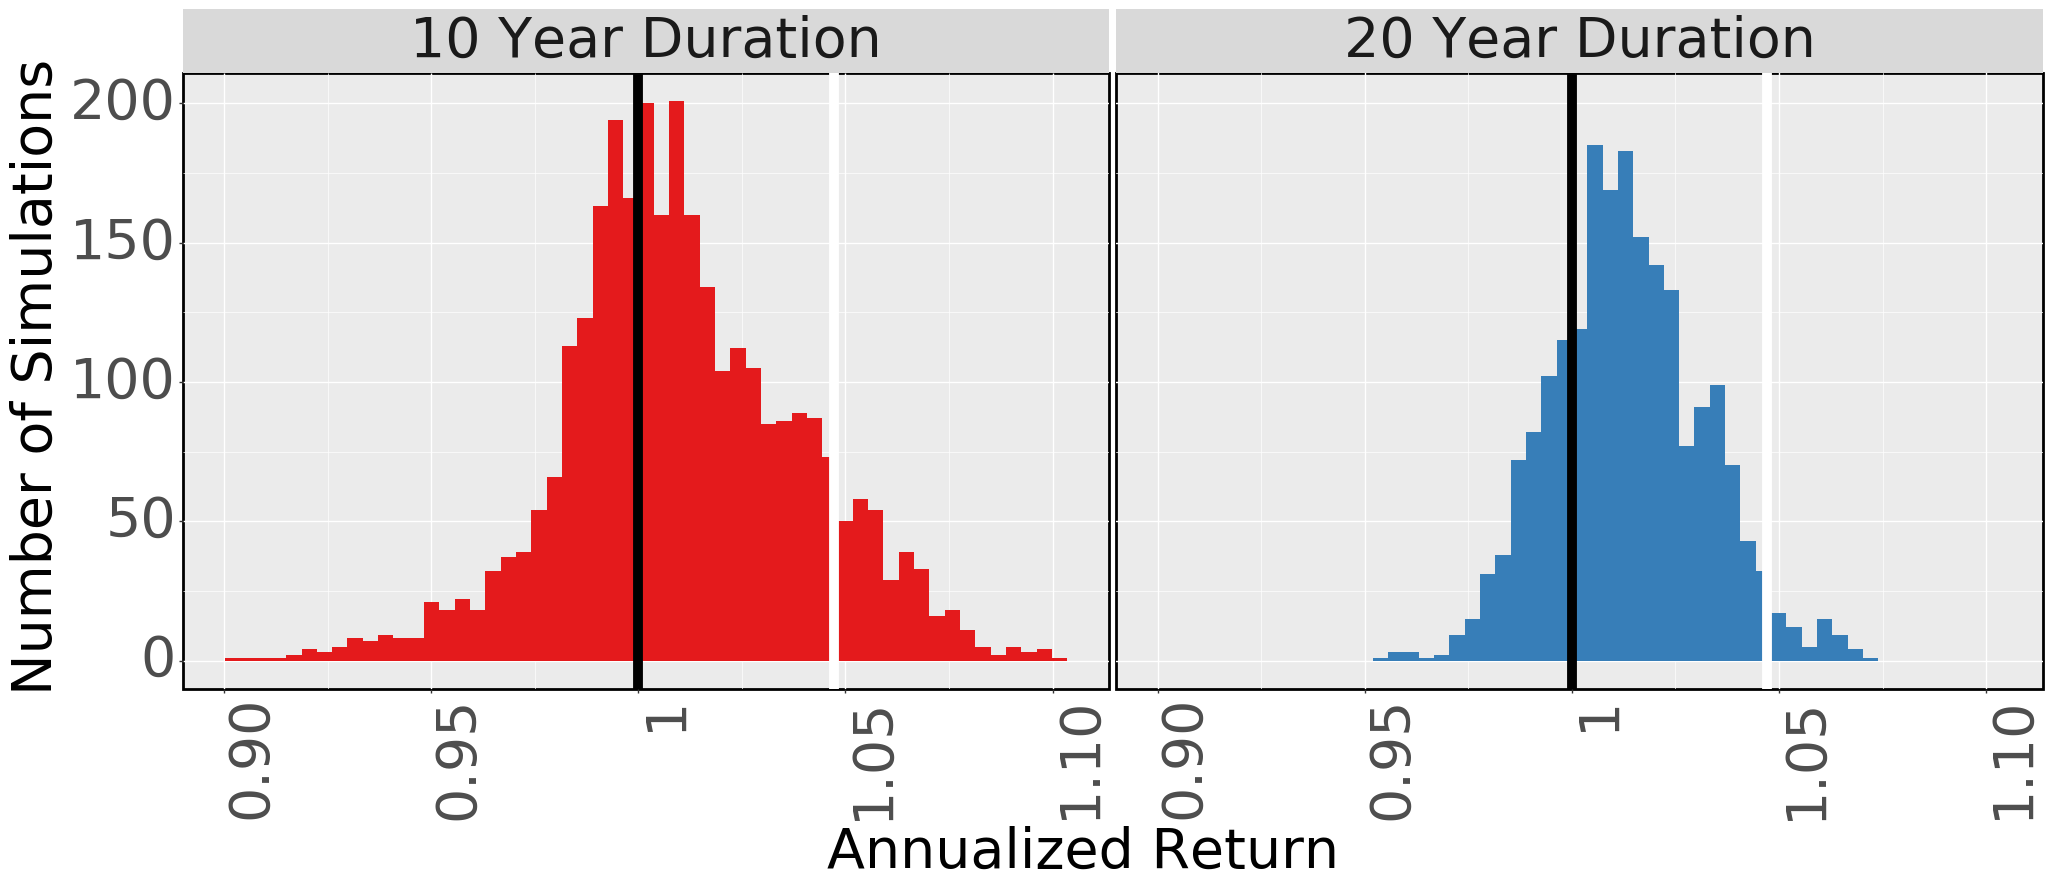

<ggplot: (8774200860876)>

In [64]:
mytbl = tbl.copy()
mytbl = mytbl.query('duration != 15')
mytbl['duration'] = mytbl['duration'].map(lambda x: f'{x} Year Duration')
mytbl['time'] = mytbl['time'].map(lambda x: f'{x}')
(
    ggplot(mytbl, aes(x='AR', fill='duration')) +
        geom_histogram(position='dodge') +
        geom_vline(xintercept=1, color='black', size=4) +
        geom_vline(xintercept=1.047123, color='white', size=4) +
        scale_fill_brewer(type='qualitative', palette=6) +
        facet_grid('~duration', scales='free_y') +
        ylab('Number of Simulations') +
        xlab('Annualized Return') +
        theme(
            text=element_text(size=40),
            figure_size=(24, 8),
            legend_position='none',
            axis_text_x=element_text(size=40, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

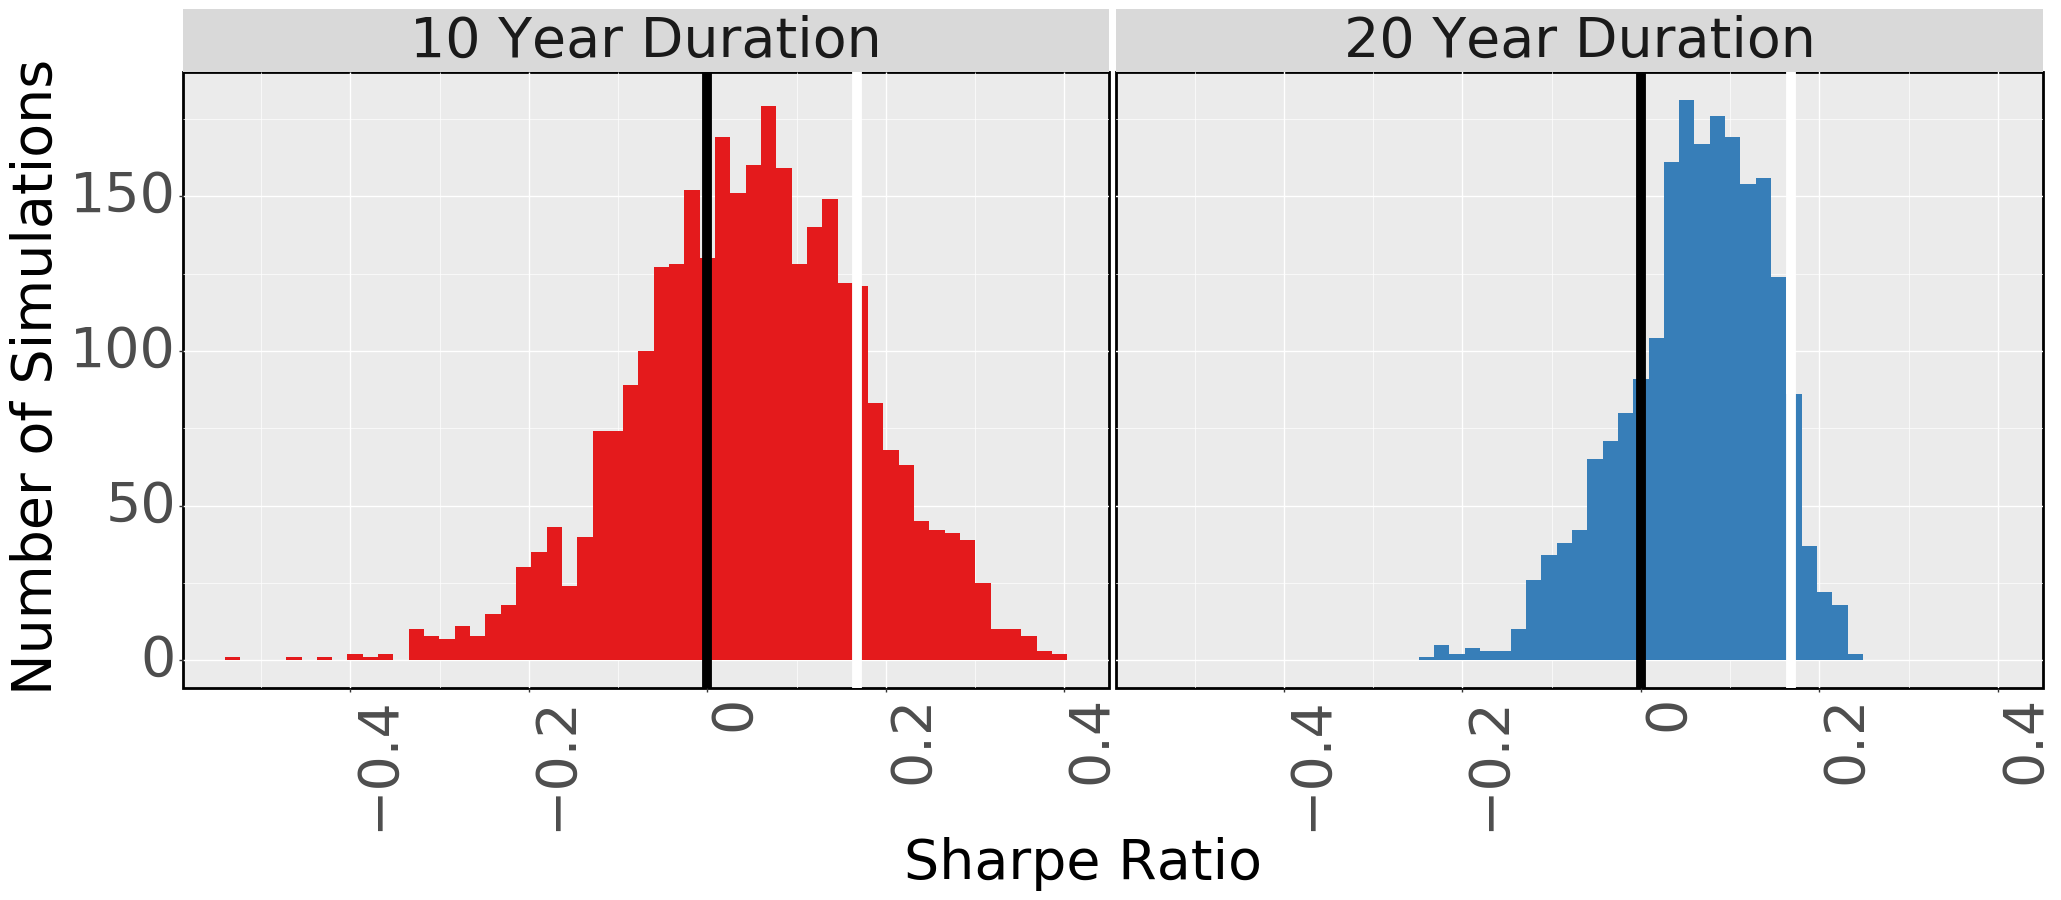

<ggplot: (8774200348494)>

In [65]:
mytbl = tbl.copy()
mytbl = mytbl.query('duration != 15')
mytbl['duration'] = mytbl['duration'].map(lambda x: f'{x} Year Duration')
mytbl['time'] = mytbl['time'].map(lambda x: f'{x}')
(
    ggplot(mytbl, aes(x='sharpe', fill='duration')) +
        geom_histogram(position='dodge') +
        geom_vline(xintercept=0, color='black', size=4) +
        geom_vline(xintercept=0.168, color='white', size=4) +
        scale_fill_brewer(type='qualitative', palette=6) +
        facet_grid('~duration', scales='free_y') +
        ylab('Number of Simulations') +
        xlab('Sharpe Ratio') +
        theme(
            text=element_text(size=40),
            figure_size=(24, 8),
            legend_position='none',
            axis_text_x=element_text(size=40, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)